In [25]:
# set variables 
REPO_NAME = "facebookresearch/dinov2"
MODEL_NAME = "dinov2_vitb14_reg"
dataset_dir = "/workspaces/LIB-HSI"
rgb_data_json = '/workspaces/dinov2/notebooks/lib_hsi_rgb.json'

learning_rate = 5e-5
epochs = 1
batch_size = 2
num_workers = 8

In [26]:
# import dependencies 

import os
from os.path import join
from torch.utils.data import Dataset
import torch
import albumentations as A 
from PIL import Image
import numpy as np
import json
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import cv2
from osgeo import gdal
from torch.utils.data import DataLoader
from transformers.modeling_outputs import SemanticSegmenterOutput
import evaluate
from torch.optim import AdamW
from tqdm.auto import tqdm


#clear cuda memory
torch.cuda.empty_cache()



In [27]:
# load json 

file_data =  open(rgb_data_json)
file_contents = json.load(file_data)

id2label ={}
id2color = {}
for i, item in enumerate(file_contents['items'], start=0):
    id2label[i] = item['name']
    id2color[i] = [item['red_value'], item['green_value'], item['blue_value']]
    
print(id2label)
print(id2color)
num_classes = len(id2label)
print(num_classes)

{0: 'Whiteboard', 1: 'Chessboard', 2: 'Tripod', 3: 'Vegetation Plant', 4: 'Metal-Frame', 5: 'Glass Window', 6: 'Brick Wall', 7: 'Miscellaneous', 8: 'Concrete Ground', 9: 'Metal-Vent', 10: 'Metal Door Knob/Handle', 11: 'Block Wall', 12: 'Concrete Wall', 13: 'Concrete Footing', 14: 'Concrete Beam', 15: 'Brick Ground', 16: 'Glass door', 17: 'Plastic Flyscreen', 18: 'Plastic Label', 19: 'Vegetation Ground', 20: 'Soil', 21: 'Metal Label', 22: 'Metal Pipe', 23: 'Metal Sheet', 24: 'Metal Smooth Sheet', 25: 'Woodchip Ground', 26: 'Wood/Timber Smooth Door', 27: 'Tiles Ground', 28: 'Pebble-Concrete Beam', 29: 'Pebble-Concrete Ground', 30: 'Pebble-Concrete Wall', 31: 'Plastic Pipe', 32: 'Metal Profiled Sheet', 33: 'Metal-Pole', 34: 'Door-plastic', 35: 'Wood/timber Vent', 36: 'Wood/timber Wall', 37: 'Wood Frame', 38: 'Metal Smooth Door', 39: 'Plastic Vent', 40: 'Concrete Window Sill', 41: 'Wood Ground', 42: 'Metal Profiled Door', 43: 'Wood/Timber Profiled Door', 44: 'Unknown'}
{0: [199, 197, 189],

In [28]:
# dataset loader 

def extract_rgb(cube, red_layer=70 , green_layer=53, blue_layer=19):

    red_img = cube[ red_layer,:,:]
    green_img = cube[ green_layer,:,:]
    blue_img = cube[ blue_layer,:,:]
        
    data=np.stack([red_img,green_img,blue_img], axis=-1)
    
    # convert from x,y,channels to channels, x, y
    # data = np.transpose(data, (2, 0, 1))
    
    return data 
  
  
  
def GDAL_imreadmulti(file_name):
    # Open the dataset
    dataset = gdal.Open(file_name)

    # Check if opened
    if dataset:
      # print("Dataset opened...")
      width = dataset.RasterXSize
      height = dataset.RasterYSize
      num_bands = dataset.RasterCount

      image_bands = []

      for band_num in range(1, num_bands+1):
        band = dataset.GetRasterBand(band_num)

        # Read band data
        band_data = band.ReadAsArray()

        # Create an OpenCV Mat from the band data
        band_mat = np.array(band_data, dtype='float32')

        # Correct the orientation of the image
        band_mat = np.transpose(band_mat)
        band_mat = cv2.flip(band_mat, 1)

        # Apply threshold and convert to 8-bit unsigned integers
        _, band_mat = cv2.threshold(band_mat, 1.0, 1.0, cv2.THRESH_TRUNC)
        band_mat = cv2.convertScaleAbs(band_mat, alpha=(255.0))

        # Add the processed band to the list
        image_bands.append(band_mat)
        
        cube=np.array(image_bands)
        
        # convert from x,y,channels to channels, x, y
        # data = np.transpose(cube, (2, 0, 1))
        
        

      return True, cube

    else:
      print("GDAL Error: ", gdal.GetLastErrorMsg())
      return False, []
  
  
class SegmentationDataset(Dataset):
    def __init__(self, image_set,  root_dir, id2color, transform=None):
        
        # image_set # train ,test, validation
        self.transform = transform
        self.root = join(root_dir,image_set)
        
        
        # Convert id2color to a numpy array for easier comparison
        self.id2color_np = np.array(list(id2color.values()))

        self.img_dir =  join(self.root, "reflectance_cubes")
        self.label_dir = join(self.root, "labels")
        
        self.img_names = [f for f in os.listdir(self.img_dir) if f.endswith('.' + 'dat')]
        self.num_images = len( self.img_names  ) 

        assert self.num_images == len(os.listdir(self.label_dir))
        
        self.img_labels = [f for f in os.listdir(self.label_dir)]
        
        # sort img_names and img_labels
        self.img_names.sort()
        self.img_labels.sort()

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        label_name, ext_label = os.path.splitext(self.img_labels[idx])
        
        hsi_name, ext_hsi = os.path.splitext(self.img_names[idx])
        
        assert label_name == hsi_name # make sure they have the same name 
        
        # read the label image 
        label_path = join(self.label_dir, self.img_labels[idx])
        label_img = Image.open(label_path).convert('RGB')
        
        label_img_np = np.array(label_img) # uint8 x,y,channels
        
        
        # print(label_name)
        
        # label_img_np = label_img_np.astype(np.float32)
        # print(label_img_np.dtype, label_img_np.shape)
        
        #convert labeled rgb image to greyscale
        label_img_greyscale = np.zeros(label_img_np.shape[:2], dtype=np.uint8)
        for i, color in enumerate(self.id2color_np):
            # Find where in the target the current color is
            mask = np.all(label_img_np == color, axis=-1)
            
            # Wherever the color is found, set the corresponding index in target_new to the current class label
            label_img_greyscale[mask] = i
        
        hsi_path = join(self.img_dir, self.img_names[idx])
        _, hsi_img = GDAL_imreadmulti(hsi_path)

        
        rgb_img = extract_rgb(hsi_img) 

        hsi_img = np.transpose(hsi_img, (1, 2, 0)) # transpose to x,y,channels for albumnetations
        
        # apply transformations  # must be in x,y,channels format        
        if self.transform:
            hsi_img_transformed = self.transform(image=hsi_img)
            transformed = self.transform(image = rgb_img, mask = label_img_greyscale)
            label_img_greyscale = self.transform(image = label_img_greyscale)
        
            hsi_img, rgb_img, label_img_greyscale = torch.tensor(hsi_img_transformed['image']), torch.tensor(transformed['image']), torch.tensor(transformed['mask'])
        else:
            hsi_img, rgb_img, label_img_greyscale = torch.tensor(hsi_img), torch.tensor(rgb_img), torch.tensor(label_img_greyscale)
            
            
        #convert from x,y,channels to channels, x, y
        hsi_img = hsi_img.permute(2,0,1)
        rgb_img = rgb_img.permute(2,0,1)
        
        #convert from uint8 to float32
        hsi_img = hsi_img.float()
        rgb_img = rgb_img.float()
        

        
        return hsi_img, rgb_img, label_img_greyscale

In [29]:
# transform not yet implemented
base_transform = A.Compose([
    A.Resize(width=448, height=448),
])

train_dataset = SegmentationDataset(image_set="train", root_dir=dataset_dir, id2color=id2color, transform=base_transform)

test_dataset = SegmentationDataset(image_set="test", root_dir=dataset_dir, id2color=id2color,  transform=base_transform)

val_dataset = SegmentationDataset(image_set="validation", root_dir=dataset_dir, id2color=id2color, transform=base_transform)

print("train dataset size: ", train_dataset.__len__())
print("test dataset size: ", test_dataset.__len__())
print("validation dataset size: ", val_dataset.__len__())

train dataset size:  393
test dataset size:  75
validation dataset size:  45


torch.Size([204, 448, 448]) torch.Size([3, 448, 448]) torch.Size([448, 448])


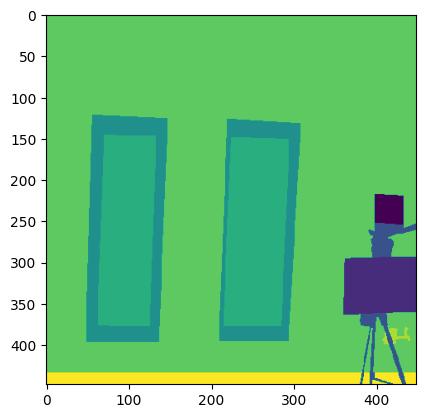

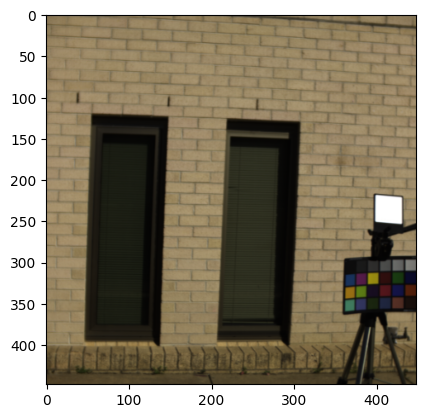

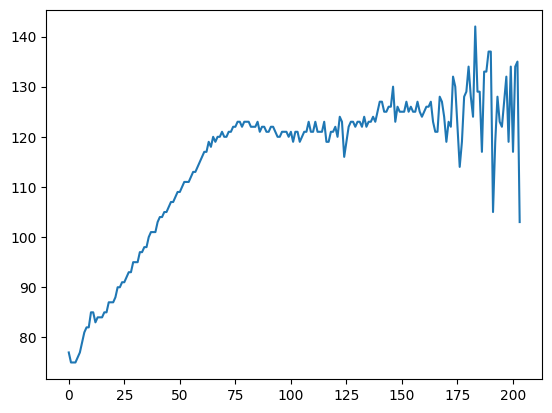

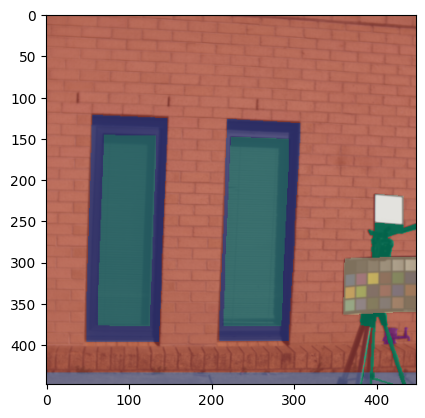

In [30]:
# get an item from the dataset
hsi, rgb, mask = train_dataset[0]

print(hsi.shape, rgb.shape, mask.shape)


# plt label image
plt.imshow(mask)
plt.show()

# plt rgb image from hsi
# convert from channels, x, y to x, y, channels
plt.imshow(rgb.permute(1,2,0).detach().cpu().numpy()/255)
plt.show()

# plot graph of pixel spectrum of first pixel in hsi
plt.plot(hsi[:,0,0])
plt.show()

mask = mask.detach().cpu().numpy()
mask_rgb = np.zeros((mask.shape[0], mask.shape[1],3) , dtype=np.float32) 

for i in range(mask_rgb.shape[0]):
        for j in range(mask_rgb.shape[1]):   
            pixel_value = int(mask[i, j])
            mask_rgb[i,j,:] = id2color[pixel_value]
            
            
# plot rgb image and label image
fused_img = cv2.addWeighted(rgb.permute(1,2,0).detach().cpu().numpy()/255, .5, mask_rgb/255, 0.5, 0)
plt.imshow(fused_img)

In [31]:
def collate_fn(inputs):


    batch = dict()
    batch["hsi_pixel_values"] = torch.stack([i[0] for i in inputs], dim=0)
    batch["rgb_pixel_values"] = torch.stack([i[1] for i in inputs], dim=0)
    batch["labels"] = torch.stack([i[2] for i in inputs], dim=0)

    return batch

# dataloader allows us to get batches of data from the datasets
# batch size and number of workers can be modified to better suit the specs of your machine
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,num_workers=num_workers)
val_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn,num_workers=num_workers)

In [32]:
batch = next(iter(train_dataloader))


for k,v in batch.items():
  if isinstance(v,torch.Tensor):
    print(k,v.shape)
    
print(batch["hsi_pixel_values"].dtype)
print(batch["rgb_pixel_values"].dtype)
print(batch["labels"].dtype)

hsi_pixel_values torch.Size([2, 204, 448, 448])
rgb_pixel_values torch.Size([2, 3, 448, 448])
labels torch.Size([2, 448, 448])
torch.float32
torch.float32
torch.uint8


In [33]:
# this is the linear classifer that is added to dinov2. It takes in the patch descriptors and outputs data related to the number of labels
class LinearClassifierNew(torch.nn.Module):
    def __init__(self, in_channels, tokenW=32, tokenH=32, num_labels=1):
        super(LinearClassifierNew, self).__init__()

        self.in_channels = in_channels # patch descriptor size
        self.width = tokenW
        self.height = tokenH
        self.classifier = torch.nn.Conv2d(in_channels, num_labels, (1,1))

    def forward(self, embeddings):
        embeddings = embeddings.reshape(-1, self.height, self.width, self.in_channels)
        embeddings = embeddings.permute(0,3,1,2)

        return self.classifier(embeddings)
    
    
class DinoV2SemanticSegmentationRegisters(torch.nn.Module):
    def __init__(self,  num_labels=1, repo_name="facebookresearch/dinov2", model_name="dinov2_vitb14_reg",   half_precision=False, device="cuda"):
        super().__init__()
        self.repo_name = repo_name
        self.model_name = model_name
        self.half_precision = half_precision
        self.device = device
        
        # load the dinov2 model 
        if self.half_precision:
            self.dinov2 = torch.hub.load(repo_or_dir=repo_name, model=model_name).half().to(self.device)
        else:
            self.dinov2= torch.hub.load(repo_or_dir=repo_name, model=model_name).to(self.device)
        
        # Get the parameters of the last layer
        last_layer_params = list(self.dinov2.parameters())[-1]
        # get the patch descriptor size for use in initializing the linear classifier layer 
        patch_descriptor_size = last_layer_params.shape[0]
        
        # Create the classifier that will be used for semantic segmentation on top of the DINOv2 model
        self.classifier = LinearClassifierNew(patch_descriptor_size, 32, 32, num_labels)
        self.classifier = self.classifier.to(self.device)
        
        # Freeze the DINOv2 model. This allows for faster training. 
        for _, param in self.dinov2.named_parameters():
            param.requires_grad = False
            
            
            
    def __call__(self, pixel_values, labels=None):
        pixel_values = pixel_values.to(self.device)
        if labels is not None:
            labels = labels.to(self.device)
        return self.forward(pixel_values=pixel_values, labels=labels)         
        
    def forward(self, pixel_values, output_hidden_states=False, output_attentions=False, labels=None):
        # Get the embeddings from the DINOv2 model which are patch descriptors
        patch_embeddings = self.dinov2.get_intermediate_layers(pixel_values)[0].squeeze()
            
        # convert to logits and upsample to the size of the pixel values
        logits = self.classifier(patch_embeddings)
        logits = torch.nn.functional.interpolate(logits, size=pixel_values.shape[2:], mode="bilinear", align_corners=False)

        loss = None
        if labels is not None:
            # important: we're going to use 0 here as ignore index 
            # as we don't want the model to learn to predict background
            loss_fct = torch.nn.CrossEntropyLoss(ignore_index=0)
            loss = loss_fct(logits.squeeze(), labels.squeeze())
        
        return  SemanticSegmenterOutput(
            loss=loss,
            logits=logits
        )

In [34]:
# intialize model
model = DinoV2SemanticSegmentationRegisters(num_labels = num_classes, repo_name=REPO_NAME, model_name=MODEL_NAME, half_precision=False, device="cuda")  

#initialize metrics for model
metric = evaluate.load("mean_iou")
metric_test = evaluate.load("mean_iou")

# set optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

# set device for processing and move model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(device)



Using cache found in /home/dino_user/.cache/torch/hub/facebookresearch_dinov2_main
INFO:dinov2:using MLP layer as FFN


cuda


In [36]:
# initialize empty data stuctures to keep track of learning performance

history_loss_train = []
history_loss_test = []

history_mean_iou_train = []
history_mean_iou_test = []

history_mean_accuracy_train = []
history_mean_accuracy_test = []

# start training
for epoch in range(epochs):
    print("Epoch:", epoch+1)
    model.train()
    for idx, batch in enumerate(tqdm(train_dataloader)):
        torch.cuda.synchronize()
        pixel_values = batch["rgb_pixel_values"].to(device)
        labels = batch["labels"].to(device).long()

        # forward pass
        outputs = model(pixel_values, labels=labels)
        loss = outputs.loss

        # zero the parameter gradients
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            predicted = outputs.logits.argmax(dim=1)

            # note that the metric expects predictions + labels as numpy arrays
            
            metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())
    
    

  
    metrics = metric.compute(num_labels=num_classes,
                                ignore_index=0,
                                reduce_labels=False,
    )
    history_loss_train.append(loss.item())
    history_mean_iou_train.append(metrics["mean_iou"])
    history_mean_accuracy_train.append(metrics["mean_accuracy"])
    
    model.eval()
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["rgb_pixel_values"].to(device)
        labels = batch["labels"].to(device).long()


        # forward pass
        outputs = model(pixel_values, labels=labels)
        test_loss = outputs.loss

        with torch.no_grad():
            predicted = outputs.logits.argmax(dim=1)

            # note that the metric expects predictions + labels as numpy arrays
            
            metric_test.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

    metrics_test = metric_test.compute(num_labels=num_classes,
                            ignore_index=0,
                            reduce_labels=False,
    )
    history_loss_test.append(test_loss.item())
    history_mean_iou_test.append(metrics_test["mean_iou"])
    history_mean_accuracy_test.append(metrics_test["mean_accuracy"])
    
    print("Train Loss: ", loss.item(), " Test Loss: ", test_loss.item())
    print("Train Mean_iou: ", metrics["mean_iou"], " Test Mean_iou: ", metrics_test["mean_iou"])
    print("Train Mean_accuracy: ", metrics["mean_accuracy"], " Test Mean_accuracy: ", metrics_test["mean_accuracy"])
  
  


Epoch: 1


  0%|          | 0/197 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
 99%|█████████▉| 196/197 [07:22<00:02,  2.26s/it]


ValueError: Expected input batch_size (45) to match target batch_size (448).

In [ ]:
# plot the training and test loss
plt.plot(history_loss_train, label="train_loss")
plt.plot(history_loss_test, label="test_loss")
plt.legend()
plt.show()

# # plot the training and validation mean iou
plt.plot(history_mean_iou_train, label="train_mean_iou")
plt.plot(history_mean_iou_test, label="test_mean_iou")
plt.legend()
plt.show()

# plot the training and validation mean accuracy
plt.plot(history_mean_accuracy_train, label="train_mean_accuracy")
plt.plot(history_mean_accuracy_test, label="test_mean_accuracy")
plt.legend()
plt.show()

torch.Size([1, 3, 448, 448])


/tmp/ipykernel_15574/1493015372.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pixel_values = torch.tensor(test_image)


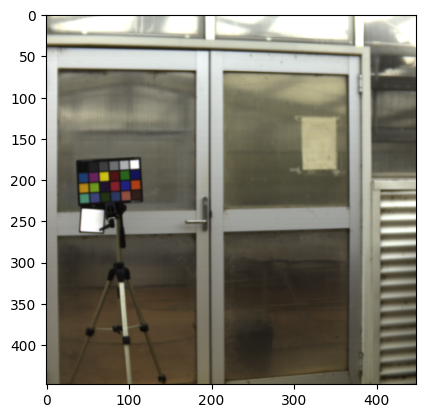

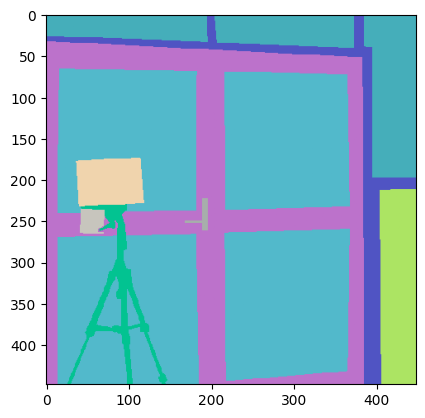

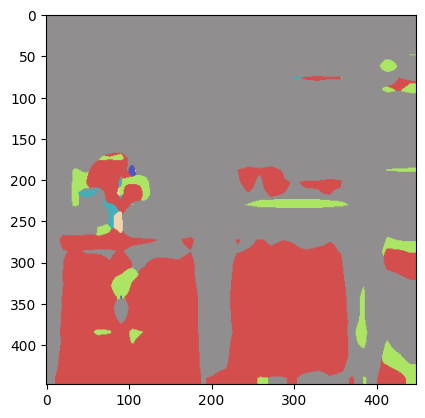

In [43]:
from PIL import Image

test_hsi_image, test_image, test_mask = test_dataset[7]
img_permute = test_image.permute(1, 2, 0)


pixel_values = torch.tensor(test_image)
pixel_values = pixel_values.unsqueeze(0) # convert to (batch_size, num_channels, height, width)
print(pixel_values.shape)

with torch.no_grad():
  outputs = model(pixel_values.to(device))

upsampled_logits = torch.nn.functional.interpolate(outputs.logits,
                                                   size=(test_image.shape[-2], test_image.shape[-1]),
                                                   mode="bilinear", align_corners=False)

predicted_map = upsampled_logits.argmax(dim=1)

plt.imshow(img_permute/255)
plt.show()


mask_np = test_mask.detach().cpu().numpy()
color_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)
# convert id to rgb values in mask 
for i in range(mask_np.shape[0]):
        for j in range(mask_np.shape[1]):                      
            pixel_value = int(mask_np[i, j])
            color_mask[i,j,:] = id2color[pixel_value]
color_mask = color_mask.astype(np.float32)
color_mask /= 255.0            
            
plt.imshow(color_mask)
plt.show()

mask_np = predicted_map.squeeze().detach().cpu().numpy()
color_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)
# convert id to rgb values in mask 
for i in range(mask_np.shape[0]):
        for j in range(mask_np.shape[1]):                      
            pixel_value = int(mask_np[i, j])
            color_mask[i,j,:] = id2color[pixel_value]
color_mask = color_mask.astype(np.float32)
color_mask /= 255.0  

plt.imshow(color_mask)
plt.show()
